In [22]:
print('Importing...')

%matplotlib inline

import glob
import os
import numpy as np
import time as systime
import re 
import textgrid as tg
import matplotlib.pyplot as plt

from scipy.stats import multivariate_normal

from bokeh.plotting import show
from bokeh.io import output_notebook
from bokeh.plotting import figure
from bokeh.layouts import gridplot
from ipyparallel import Client
import _pickle as pickle

import sys

print('success')

Importing...
success


- we need to start with a top level string 
- do some edit operations to get bottom level
- have each bottom level type index a 3-state hmm
- for each 3 state hmm
	- sample some transitions etc 
	- have each state index a GMM
	- each GMM generate a 2-dimensional vector 
    
- input: top level string
- parameters we need to specify: 
	- edit operation parameters
		- ins_top (1)
		- ins_bot (n)
		- sub (n) 
	- hmm 
		- initial (3)
		- transition (3x3)
		- emission (3xm)
    - GMM
		- num of components 
		- mean, variance for each component 
		- mixture proportions 

for simplicity, let's make all top level strings 10 characters long.
let's have a 4 character alphabet 

In [2]:
top_alphabet = [0,1,2,3]
print('success')

success


 let's have 1 more bottom level PLU



In [3]:
bot_alphabet = [0,1,2,3,4]
print('success')

success


Now we get some random sequences of top letters that represent a top alphabet

In [4]:
top_strings = np.random.choice(top_alphabet, (100, 10))
print('success')

success


Now we define prob distributions over ins, sub, del, and sample edit operations for each top-level PLU

In [5]:
# Dirichlet parameters for distribution over edit ops for each of the top PLUs 
# (plus distribution over final insert bottoms)
# (insert_top prob) (insert_bottom probs) (sub probs)
ops_priors = [
    [1,1,2,1,1,1,3,2,1,1,1],
    [2,1,1,2,1,1,1,3,2,1,1],
    [3,1,1,1,2,1,1,1,3,1,1],
    [3,2,1,1,1,1,1,2,1,3,1],

]

# ops_priors = [
#     [1,.1,.1,.1,.1,.1,3,2,1,1,1],
#     [2,.1,.1,.1,.1,.1,1,3,2,1,1],
#     [3,.1,.1,.1,.1,.1,1,1,3,1,1],
#     [3,.1,.1,.1,.1,.1,1,2,1,3,1],
# ]

# Draw a sample from each Dirichlet to get the distribution
ops_dists = [np.random.dirichlet(i) for i in ops_priors]

# ins_top = [2]
# ins_bot = [.5,1,.5,4,2]
# sub = [[100, 3, 4, 1],
#       [.5, 100, 2, 2],
#       [2, .75, 100, 3],
#       [3,2,1,100]]


# full_dir = np.array(ins_top + ins_bot + sub[0] + sub[1] + sub[2] + sub[3], dtype=np.float64)
# # normalize 
# full_dir = full_dir/np.sum(full_dir)
# print(full_dir)

print('success')


success


In [6]:
bottom_strings = []
i = 0
while i < len(top_strings):
    ts = top_strings[i]
    j = 0
    bs = []
    while j < len(ts):
#         sample some edit operation
#         eo = np.argmax(np.random.multinomial(1, full_dir))
        eo = np.argmax(np.random.multinomial(1, ops_dists[ts[j]]))
#         print(ops_dists[ts[j]])
#         print(eo)
        if eo == 0:
#             insert top, do nothing
            j+=1
        elif eo >= 1 and eo <= 5:
            bc = bot_alphabet[eo-1]
            bs.append(bc)
        else:
#             sub
#             bc = bot_alphabet[(eo-5)%4]
            bc = bot_alphabet[(eo-6)] 
            bs.append(bc)
            j+=1
    i+=1
    print("num of top string PLUs: ", len(ts))
    print("num of bottom string PLUs: ", len(bs))
    print("\n")
    bottom_strings.append(bs)

print(bottom_strings)
print(len(bottom_strings[0]))



num of top string PLUs:  10
num of bottom string PLUs:  14


num of top string PLUs:  10
num of bottom string PLUs:  16


num of top string PLUs:  10
num of bottom string PLUs:  10


num of top string PLUs:  10
num of bottom string PLUs:  9


num of top string PLUs:  10
num of bottom string PLUs:  23


num of top string PLUs:  10
num of bottom string PLUs:  12


num of top string PLUs:  10
num of bottom string PLUs:  13


num of top string PLUs:  10
num of bottom string PLUs:  13


num of top string PLUs:  10
num of bottom string PLUs:  9


num of top string PLUs:  10
num of bottom string PLUs:  13


num of top string PLUs:  10
num of bottom string PLUs:  17


num of top string PLUs:  10
num of bottom string PLUs:  13


num of top string PLUs:  10
num of bottom string PLUs:  9


num of top string PLUs:  10
num of bottom string PLUs:  16


num of top string PLUs:  10
num of bottom string PLUs:  12


num of top string PLUs:  10
num of bottom string PLUs:  14


num of top string PLUs:  10

Let's define the HMM/GMM parameters

In [7]:
# transition = [[.5, .5, 0],
#              [0, .5, .5],
#              [.75, 0, .25]]

components = []
# Distribution over components for each bottom PLU state
components.append([[.7,.3],
             [.9,.1],
             [.3,.7]])
components.append([[.3,.7],
             [.5,.5],
             [.8,.2]])
components.append([[.4,.6],
             [.2,.8],
             [.9,.1]])
components.append([[.5,.5],
             [.3,.7],
             [.6,.4]])
components.append([[.1,.9],
             [.6,.4],
             [.7,.3]])


# We need a set of parameters for each component
# for each HMM state for each bottom PLU
# So in this case, we need 2 * 3 * 5 = 30 sets of parameters
component_parameters = [
    [
        [
            [[0,0], [[1,0],[0,1]]], # bottom PLU 0, HMM state 0, component 0
            [[0.1,0.1], [[1,0],[0,1]]]  # bottom PLU 0, HMM state 0, component 1
        ],
        [
             [[0.2,0.2], [[1,0],[0,1]]], # bottom PLU 0, HMM state 1, component 0
             [[0.3,0.03], [[1,0],[0,1]]]  # bottom PLU 0, HMM state 1, component 1
        ],
        [
            [[0.4,0.4], [[1,0],[0,1]]], # bottom PLU 0, HMM state 2, component 0
            [[0.5,0.5], [[1,0],[0,1]]]  # bottom PLU 0, HMM state 2, component 1
        ]
    ],
    [
        [
            [[1.0,1.0], [[1,0],[0,1]]], # bottom PLU 1, HMM state 0, component 0
            [[1.1,1.1], [[1,0],[0,1]]]  # bottom PLU 1, HMM state 0, component 1
        ],
        [
             [[1.2,1.2], [[1,0],[0,1]]], # bottom PLU 1, HMM state 1, component 0
             [[1.3,1.3], [[1,0],[0,1]]]  # bottom PLU 1, HMM state 1, component 1
        ],
        [
            [[1.4,1.4], [[1,0],[0,1]]], # bottom PLU 1, HMM state 2, component 0
            [[1.5,1.5], [[1,0],[0,1]]]  # bottom PLU 1, HMM state 2, component 1
        ]
    ],
    [        
        [
            [[2.0,2.0], [[1,0],[0,1]]], # bottom PLU 2, HMM state 0, component 0
            [[2.1,2.1], [[1,0],[0,1]]]  # bottom PLU 2, HMM state 0, component 1
        ],
        [
             [[2.2,2.2], [[1,0],[0,1]]], # bottom PLU 2, HMM state 1, component 0
             [[2.3,2.3], [[1,0],[0,1]]]  # bottom PLU 2, HMM state 1, component 1
        ],
        [
            [[2.4,2.4], [[1,0],[0,1]]], # bottom PLU 2, HMM state 2, component 0
            [[2.5,2.5], [[1,0],[0,1]]]  # bottom PLU 2, HMM state 2, component 1
        ]
    ],
    [
        [
            [[3.0,3.0], [[1,0],[0,1]]], # bottom PLU 3, HMM state 0, component 0
            [[3.1,3.1], [[1,0],[0,1]]]  # bottom PLU 3, HMM state 0, component 1
        ],
        [
             [[3.2,3.2], [[1,0],[0,1]]], # bottom PLU 3, HMM state 1, component 0
             [[3.3,3.3], [[1,0],[0,1]]]  # bottom PLU 3, HMM state 1, component 1
        ],
        [
            [[3.4,3.4], [[1,0],[0,1]]], # bottom PLU 3, HMM state 2, component 0
            [[3.5,3.5], [[1,0],[0,1]]]  # bottom PLU 3, HMM state 2, component 1
        ]
    ],
    [
        [
            [[4.0,4.0], [[1,0],[0,1]]], # bottom PLU 4, HMM state 0, component 0
            [[4.1,4.1], [[1,0],[0,1]]]  # bottom PLU 4, HMM state 0, component 1
        ],
        [
             [[4.2,4.2], [[1,0],[0,1]]], # bottom PLU 4, HMM state 1, component 0
             [[4.3,4.3], [[1,0],[0,1]]]  # bottom PLU 4, HMM state 1, component 1
        ],
        [
            [[4.4,4.4], [[1,0],[0,1]]], # bottom PLU 4, HMM state 2, component 0
            [[4.5,4.5], [[1,0],[0,1]]]  # bottom PLU 4, HMM state 2, component 1
        ]
    ]


]

print('success')
# n1 = [[0,0], [[1,0],[0,1]]]
# n2 = [[10, 10], [[1,0],[0,1]]]


success


In [8]:
print('running...')

def sample_HMMGMM(bs):
    mfccs = []
    for i, char in enumerate(bs):
        vec = None
#         if i%10 == 0:
#             print("done with ", i)
#         start_state = np.random.choice([0,1,2], p=init)
        curr_state = 0
#       get the mfcc vector and transition
        while curr_state < 3:
            gmm_component_choice = np.random.choice(2,p=components[char][curr_state])
            vec = np.random.multivariate_normal(*component_parameters[char][curr_state][gmm_component_choice])
#             vec = components[curr_state][0]*np.random.multivariate_normal(*n1) + \
#                     components[curr_state][1]*np.random.multivariate_normal(*n2)
            
            mfccs.append(vec)
#             new_curr_state = np.random.choice([0,1,2], p=transition[curr_state])
            # Transition to next state with 50% probability
            curr_state = np.random.choice([curr_state,curr_state+1],p=[0.5,0.5])
#             if curr_state == 2 and new_curr_state == 0:
    #         get the mfcc vector and transition
#             curr_state = new_curr_state
    return np.array(mfccs)

all_data = []


for i, bs in enumerate(bottom_strings):
    print("num of bottom PLUs: ", len(bs))
    mfccs = sample_HMMGMM(bs)
    print("num of frames: ", mfccs.shape[0])
    print("frames per PLU: ", mfccs.shape[0]/float(len(bs)))
    
    all_data.append(mfccs)

print(all_data[0].shape)

print('success')
        
# for i,line in enumerate(all_data):
#     with open("/Users/esteng/ULD/audio/example_2d/sent_{}.fea", "w") as f1:
        
        

running...
num of bottom PLUs:  14
num of frames:  68
frames per PLU:  4.857142857142857
num of bottom PLUs:  16
num of frames:  93
frames per PLU:  5.8125
num of bottom PLUs:  10
num of frames:  50
frames per PLU:  5.0
num of bottom PLUs:  9
num of frames:  55
frames per PLU:  6.111111111111111
num of bottom PLUs:  23
num of frames:  125
frames per PLU:  5.434782608695652
num of bottom PLUs:  12
num of frames:  70
frames per PLU:  5.833333333333333
num of bottom PLUs:  13
num of frames:  84
frames per PLU:  6.461538461538462
num of bottom PLUs:  13
num of frames:  63
frames per PLU:  4.846153846153846
num of bottom PLUs:  9
num of frames:  70
frames per PLU:  7.777777777777778
num of bottom PLUs:  13
num of frames:  69
frames per PLU:  5.3076923076923075
num of bottom PLUs:  17
num of frames:  82
frames per PLU:  4.823529411764706
num of bottom PLUs:  13
num of frames:  80
frames per PLU:  6.153846153846154
num of bottom PLUs:  9
num of frames:  64
frames per PLU:  7.111111111111111
n

In [9]:
def collect_data_stats(data):
    """Job to collect the statistics."""
    # We  re-import this module here because this code will run
    # remotely.
    
    stats_0 = data.shape[0]
    stats_1 = data.sum(axis=0)
    stats_2 = (data**2).sum(axis=0)
    retval = (
        stats_0,
        stats_1,
        stats_2
    )
    return retval

data_stats = list(map(collect_data_stats, all_data))

print('success')

success


In [10]:

def accumulate_stats(data_stats):
    n_frames = data_stats[0][0]
    mean = data_stats[0][1]
    var = data_stats[0][2]
    for stats_0, stats_1, stats_2 in data_stats[1:]:
        n_frames += stats_0
        mean += stats_1
        var += stats_2
    mean /= n_frames
    var = (var / n_frames) - mean**2

    data_stats = {
        'count': n_frames,
        'mean': mean,
        'var': var
    }
    return data_stats

final_data_stats = accumulate_stats(data_stats)

print('success')

success


In [12]:
print("Running...")

import subprocess
import amdtk
num_tops = 4

print("Finished imports in ipython notebook.")

print(len(all_data))
print(len(top_strings))
all_data_and_tops = list(zip(all_data, top_strings))
#print(all_data_and_tops[0])

print("starting engines")
subprocess.Popen(['ipcluster', 'start',' --profile', 'default',' -n', '4', '--daemonize'])
subprocess.Popen(['sleep', '10']).communicate()


rc = Client(profile='default')
dview = rc[:]
print('Connected to', len(dview), 'jobs.')


elbo = []
time = []
def callback(args):
    elbo.append(args['lower_bound'])
    time.append(args['time'])
    print('elbo=' + str(elbo[-1]), 'time=' + str(time[-1]))
 

print("Creating phone loop model...")
conc = 0.1

n_units=5  # number of acoustic units
n_states=3   # number of states per unit
n_comp_per_state=3   # number of Gaussians per emission


model = amdtk.PhoneLoopNoisyChannel.create(
    n_units=n_units,  # number of acoustic units
    n_states=n_states,   # number of states per unit
    n_comp_per_state=n_comp_per_state,   # number of Gaussians per emission
    n_top_units=num_tops, # size of top PLU alphabet
    mean=np.zeros_like(final_data_stats['mean']), 
    var=np.ones_like(final_data_stats['var']),
    max_slip_factor=.05
    #concentration=conc
)


print("Creating VB optimizer...")   
optimizer = amdtk.ToyNoisyChannelOptimizer(
    dview, 
    final_data_stats, 
    args= {'epochs': 3,
     'batch_size': 4,
     'lrate': 0.01,
     'pkl_path': "example_test",
     'log_dir': 'logs'},
    model=model,
    dir_path='dir'
)

print("Running VB optimization...")
begin = systime.time()
print("running with toy data")
print('len(all_data_and_tops[0])')
print(len(all_data_and_tops[0]))
optimizer.run(all_data_and_tops, callback)
end = systime.time()
print("VB optimization took ",end-begin," seconds.")

# fig1 = figure(
#     x_axis_label='time (s)', 
#     y_axis_label='ELBO',
#     width=400, 
#     height=400
# )
# x = np.arange(0, len(elbo), 1)
# fig1.line(x, elbo)
#show(fig1)

print("\nDECODING\n")

date_string = systime.strftime("textgrids_%Y-%m-%d_%H:%M")

# Need to change this according to 
samples_per_sec = 100

all_data_and_tops = list(zip(all_data, top_strings))

for data, tops in all_data_and_tops:

    # Normalize the data
    data_mean = np.mean(data)
    data_var = np.var(data)
    data = (data-data_mean)/np.sqrt(data_var)

    #result = model.decode(data, tops, state_path=False)
    #result_path = model.decode(data, tops, state_path=True)
    (result_intervals, edit_path, plu_path) = model.decode(data, tops, phone_intervals=True, edit_ops=True)

    print("---")
    print("Phone sequence:")
    print(result_intervals)
    print(edit_path)
    

Running...
Finished imports in ipython notebook.
100
100
starting engines
Connected to 4 jobs.
Creating phone loop model...
[-2.92896825 -2.92896825 -2.92896825 -2.92896825 -2.92896825 -2.92896825
 -2.92896825 -2.92896825 -2.92896825 -2.92896825 -2.92896825]
[-2.92896825 -2.92896825 -2.92896825 -2.92896825 -2.92896825 -2.92896825
 -2.92896825 -2.92896825 -2.92896825 -2.92896825 -2.92896825]
[-2.92896825 -2.92896825 -2.92896825 -2.92896825 -2.92896825 -2.92896825
 -2.92896825 -2.92896825 -2.92896825 -2.92896825 -2.92896825]
[-2.92896825 -2.92896825 -2.92896825 -2.92896825 -2.92896825 -2.92896825
 -2.92896825 -2.92896825 -2.92896825 -2.92896825 -2.92896825]
Creating VB optimizer...
importing numpy on engine(s)
importing read_htk from amdtk on engine(s)
importing _pickle on engine(s)
importing os on engine(s)
Running VB optimization...
running with toy data
len(all_data_and_tops[0])
2
[[  0.02710355   0.2697666    0.02758055]
 [  0.07684969   0.29018356   0.19805797]
 [  0.28562557   0.15

[[  4.70856823e-03   2.21537725e-02   3.48135858e-03]
 [  8.67665756e-03   1.30313048e-02   1.27150858e-02]
 [  1.63662889e-02   7.81087987e-03   1.14003494e-02]
 [  6.79610795e-03   1.12638494e-02   8.46332050e-03]
 [  1.35095773e-02   8.31519909e-03   1.73120708e-03]
 [  9.74011456e-03   1.82677500e-02   5.34574891e-03]
 [  3.53907444e-01   7.88730161e-01   6.02702795e-01]
 [  1.13838039e+00   4.24514350e+00   5.17854870e-01]
 [  8.01930602e-01   3.30337509e+00   6.15047253e-01]
 [  2.35814756e-01   1.75797985e-01   1.41715074e+00]
 [  1.20646264e+00   6.24148838e-01   6.87988398e-01]
 [  1.19270235e+00   8.98232459e-01   2.52950383e-01]
 [  1.22573019e+00   1.05024561e+00   1.24181658e+01]
 [  1.14881108e+00   4.87635926e+00   1.45233049e+01]
 [  1.78581800e+00   8.77448500e+00   2.95498242e+00]]
[[  1.03894978e-03   6.75803297e-03  -1.41483628e-03  -2.96241263e-03
    4.70856823e-03   4.70856823e-03   4.70856823e-03   4.70856823e-03]
 [  1.08993962e-02   2.28706279e-02   5.89349780

[[  3.67570866e-04   1.69028689e-03   2.66574562e-04]
 [  6.44409013e-04   9.40507622e-04   9.55425727e-04]
 [  1.20203528e-03   5.61713544e-04   8.48618601e-04]
 [  3.82475525e-04   6.31931192e-04   4.61428163e-04]
 [  7.63744939e-04   4.49326997e-04   1.01996803e-04]
 [  5.33588769e-04   1.00943704e-03   2.96263275e-04]
 [  4.50969874e-01   1.08136302e+00   8.05071078e-01]
 [  1.07100190e+00   4.26844890e+00   4.86914194e-01]
 [  8.33520525e-01   3.84122917e+00   6.26104944e-01]
 [  2.57942757e-01   1.51584966e-01   2.43568350e+00]
 [  1.99627680e+00   7.23215101e-01   8.06056368e-01]
 [  2.22599020e+00   9.15769968e-01   2.01975605e-01]
 [  9.89185835e-01   8.14420235e-01   1.33262237e+01]
 [  6.36936495e-01   3.18299762e+00   1.18088920e+01]
 [  1.86720423e+00   9.42825417e+00   2.75465957e+00]]
[[  8.01872644e-05   5.25557716e-04  -1.09272069e-04  -2.27812246e-04
    3.67570866e-04   3.67570866e-04   3.67570866e-04   3.67570866e-04]
 [  6.42805670e-04   1.56838185e-03   3.88228443

ValueError: too many values to unpack (expected 2)

In [13]:
component_parameters_flat1 = []
_ = [component_parameters_flat1.extend(x) for x in component_parameters]
component_parameters_flat = []
_ = [component_parameters_flat.extend(x) for x in component_parameters_flat1]

learned_components = model.components
learned_posteriors = [comp.posterior for comp in learned_components]
dimensionality = all_data[0].shape[1]
learned_natural_params = [post.natural_params.reshape((-1,dimensionality)) for post in learned_posteriors]
learned_means = [ n[1]/n[2] for n in learned_natural_params ]
learned_vars = [ (n[0]-((n[1]**2)/n[2]))/(n[3]+1) for n in learned_natural_params ]
print(learned_means)
print(learned_vars)


[array([-0.59845495, -1.34564648]), array([ 0.89225261,  0.13026364]), array([-1.47177654, -0.72030257]), array([ 0.0316949 , -0.69051689]), array([ 0.78136553,  0.6809099 ]), array([ 0.4167334,  0.3874042]), array([ 0.32043139,  1.07083008]), array([ 0.98466489, -0.28675586]), array([-1.39624959,  0.92615885]), array([-0.43077278, -0.43356409]), array([-0.05574365,  0.29682063]), array([-0.69503881,  0.84405183]), array([ 0.83239625,  0.54340653]), array([-1.03538304, -1.6435585 ]), array([ 2.09850397, -0.26851534]), array([ 0.80023715, -0.32308805]), array([ 0.52815782,  0.35391015]), array([-1.11217073, -0.95645764]), array([-0.38865927,  0.15475553]), array([ 0.64748106,  0.30435544]), array([ 0.20124653,  0.22087308]), array([ 1.20368032,  0.34227452]), array([ 1.59467267,  1.96950314]), array([ 0.08175752,  1.8281096 ]), array([-0.79331559, -0.23397236]), array([ 0.92796596,  0.62109954]), array([-1.01144076,  0.79852882]), array([ 0.81962441, -0.44255899]), array([-1.50348668,  

30
54
45
54
[array([-0.59845495, -1.34564648]), array([ 0.89225261,  0.13026364]), array([-1.47177654, -0.72030257]), array([ 0.0316949 , -0.69051689]), array([ 0.78136553,  0.6809099 ]), array([ 0.4167334,  0.3874042]), array([ 0.32043139,  1.07083008]), array([ 0.98466489, -0.28675586]), array([-1.39624959,  0.92615885]), array([-0.43077278, -0.43356409]), array([-0.05574365,  0.29682063]), array([-0.69503881,  0.84405183]), array([ 0.83239625,  0.54340653]), array([-1.03538304, -1.6435585 ]), array([ 2.09850397, -0.26851534]), array([ 0.80023715, -0.32308805]), array([ 0.52815782,  0.35391015]), array([-1.11217073, -0.95645764]), array([-0.38865927,  0.15475553]), array([ 0.64748106,  0.30435544]), array([ 0.20124653,  0.22087308]), array([ 1.20368032,  0.34227452]), array([ 1.59467267,  1.96950314]), array([ 0.08175752,  1.8281096 ]), array([-0.79331559, -0.23397236]), array([ 0.92796596,  0.62109954]), array([-1.01144076,  0.79852882]), array([ 0.81962441, -0.44255899]), array([-1

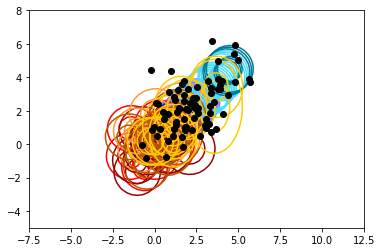

In [24]:


def gaussian_2d(x, y, dist):
    return dist.pdf([x,y])

gaussian_2d_v = np.vectorize(gaussian_2d)


def plot_gauss_2d(mean, cov, xlim=(-2.0, 2.0), ylim=(-2.0, 2.0), colors='k'):
    mv = multivariate_normal(mean=mean, cov=cov)
    x = np.linspace(*xlim)
    y = np.linspace(*ylim)
    X, Y = np.meshgrid(x, y)
    Z = gaussian_2d_v(X, Y, mv)
    CS = plt.contour(X, Y, Z, 2, colors=colors)
    #fmt = {CS.levels[0]: '95%', CS.levels[1]: '99%'}
    #plt.clabel(CS, fmt=fmt)
    
plt.figure()
plt.axis('equal')
xlim = (-5, 10)
ylim = (-5, 8)
# plot_gauss_2d(mean=[0,1], cov=[[1,0.5],[0.5,1]])
# plot_gauss_2d(mean=[1,0], cov=[[1,-0.5],[-0.5,1]])

component_parameters

def list_repeat(given_list, repeat_factor):
    return_list = []
    for item in given_list:
        return_list.extend([item]*repeat_factor)
    return return_list


colors_given_list = ['#0000ff', '#8080ff', '#4ddbff', '#007a99', '#00cc00', '#008000']
colors_learned_list = ['#ff0000', '#990000', '#ff9933', '#b35900', '#ffcc00', '#ff6633']


colors_given = list_repeat(colors_given_list, n_states*n_comp_per_state)
colors_learned = list_repeat(colors_learned_list, n_states*n_comp_per_state)


print(len(component_parameters_flat))
print(len(colors_given))
print(len(learned_means))
print(len(colors_learned))

print(learned_means)
print(learned_vars)



# Plot gaussians used to generate data
_ = [ plot_gauss_2d(mean=comp[0], cov=comp[1], xlim=xlim, ylim=ylim, colors=color) for comp, color in zip(component_parameters_flat, colors_given)]

# Plot gaussians learned from data
_ = [ plot_gauss_2d(mean=mean, cov=[[var[0],0],[0,var[1]]], xlim=xlim, ylim=ylim, colors=color) for mean, var, color in zip(learned_means, learned_vars, colors_learned)]

# Plot data
plt.plot(mfccs[:,0], mfccs[:,1], 'ko')